# Granger causality demo

#### 8th May 2024

cMLP demo from the work of [Tank et. al](https://arxiv.org/abs/1802.05842)

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_var
from models.cmlp import cMLP, cMLPSparse, train_model_ista, train_unregularized, train_model_adam

max_iter_max = 30000
check_every = np.floor(np.sqrt(max_iter_max))

In [18]:
# For GPU acceleration
device = torch.device('cpu')# torch.device('cuda')

In [ ]:
# Simulate data
X_np, beta, GC = simulate_var(p=10, T=500, lag=3, sparsity = 0.2)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

In [ ]:
#print(beta)
#print(GC)
print(X.shape)
print(X.shape[-1])

In [ ]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

In [ ]:
# Set up model
cmlp = cMLP(X.shape[-1], lag=5, hidden=[100])#.cuda(device=device)

In [ ]:
# Train with ISTA
train_loss_list = train_model_ista(
    cmlp, X, lam=0.002, lam_ridge=1e-2, lr=5e-2, penalty='H', 
    max_iter=max_iter_max,
    check_every=check_every)

In [ ]:
# Loss function plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cMLP training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

In [ ]:
# Verify learned Granger causality
GC_est = cmlp.GC().cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_title('GC estimated')
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()

In [ ]:
# Verify lag selection
for i in range(len(GC_est)):
    # Get true GC
    GC_lag = np.zeros((5, len(GC_est)))
    GC_lag[:3, GC[i].astype(bool)] = 1.0

    # Get estimated GC
    GC_est_lag = cmlp.GC(ignore_lag=False, threshold=False)[i].cpu().data.numpy().T[::-1]

    # Make figures
    fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
    axarr[0].imshow(GC_lag, cmap='Blues', extent=(0, len(GC_est), 5, 0))
    axarr[0].set_title('Series %d true GC' % (i + 1))
    axarr[0].set_ylabel('Lag')
    axarr[0].set_xlabel('Series')
    axarr[0].set_xticks(np.arange(len(GC_est)) + 0.5)
    axarr[0].set_xticklabels(range(len(GC_est)))
    axarr[0].set_yticks(np.arange(5) + 0.5)
    axarr[0].set_yticklabels(range(1, 5 + 1))
    axarr[0].tick_params(axis='both', length=0)

    axarr[1].imshow(GC_est_lag, cmap='Blues', extent=(0, len(GC_est), 5, 0))
    axarr[1].set_title('Series %d estimated GC' % (i + 1))
    axarr[1].set_ylabel('Lag')
    axarr[1].set_xlabel('Series')
    axarr[1].set_xticks(np.arange(len(GC_est)) + 0.5)
    axarr[1].set_xticklabels(range(len(GC_est)))
    axarr[1].set_yticks(np.arange(5) + 0.5)
    axarr[1].set_yticklabels(range(1, 5 + 1))
    axarr[1].tick_params(axis='both', length=0)

    # Mark nonzeros
    for i in range(len(GC_est)):
        for j in range(5):
            if GC_est_lag[j, i] > 0.0:
                rect = plt.Rectangle((i, j), 1, 1, facecolor='none', edgecolor='green', linewidth=1.0)
                axarr[1].add_patch(rect)

    plt.show()

# Train sparsified model

In [ ]:
# Create a debiased model
sparsity = cmlp.GC().bool()
cmlp_sparse = cMLPSparse(X.shape[-1], sparsity, 
                         lag=5, hidden=[100])#.cuda(device=device)

# Train
train_loss_list = train_unregularized(cmlp_sparse, X, lr=1e-3, 
                                      max_iter=max_iter_max,
                                      check_every=check_every, 
                                      verbose=1)

In [ ]:
# Plot loss function
plt.figure(figsize=(10, 5))
plt.title('Debiased model training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.plot(100 * np.arange(len(train_loss_list)), train_loss_list)
plt.show()

In [ ]:
# Get optimal forecasts using VAR parameters
X_optimal_forecast = np.zeros((X.shape[-1], 1000-3))
for t in range(1000-3):
    X_optimal_forecast[:, t] = np.dot(beta, X_np.T[:, t:(t+3)].flatten(order='F'))
X_optimal_forecast = X_optimal_forecast.T

# Forecast using debiased cMLP
X_pred = cmlp_sparse(X)

# Plot actual data and forecasts
num_points = 25

for i in range(X.shape[-1]):
    plt.figure(figsize=(10, 5))
    plt.plot(X[0, 3:num_points+3, i].cpu().data.numpy(), label='Actual')
    plt.plot(X_pred[0, :num_points, i].cpu().data.numpy(), label='cMLP forecasting')
    plt.plot(X_optimal_forecast[:num_points, i], label='Optimal forecasting')
    plt.legend(loc='upper right')
    plt.title('Series %d forecasting' % (i + 1))
    plt.show()

## Financial data

In [19]:
import yfinance as yf
import numpy as np

# Define the symbols
# symbols = ['TTF=F', 'NG=F', 'BAYRY', 'VWAGY', '^GDAXI', 'LNG', 'SHEL', 'EURUSD=X']
symbols = [
    'TTF=F', 'NG=F', 'BAYRY', 'VWAGY', '^GDAXI', 'LNG', 'SHEL', 'EURUSD=X',
    #'GAZP.ME', 
    'EURRUB=X', 
    'RELIANCE.BO'
]
# Fetch data for each symbol
data = {}
for symbol in symbols:
    ticker = yf.Ticker(symbol)
    data[symbol] = ticker.history(period="5y")['Close']

# Ensure all time series have the same length
min_length = min(len(data[symbol]) for symbol in symbols)

# Trim each series to the minimum length
for symbol in symbols:
    data[symbol] = data[symbol][-min_length:]

# Normalize each time series by dividing by its average value
normalized_data = {}
for symbol in symbols:
    avg_value = data[symbol].mean()
    normalized_data[symbol] = data[symbol] / avg_value

# Stack the normalized time series data into a single numpy array
time_series_data = np.array([normalized_data[symbol].values for symbol in symbols])

# Reshape to (1, number_timesteps, number_time_series)
time_series_data2 = time_series_data.T[np.newaxis, :, :]

print(time_series_data.shape)  # Should print (1, min_length, 10)


(10, 1217)


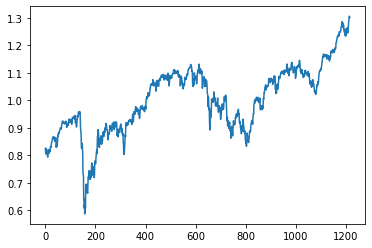

In [20]:
plt.plot(time_series_data[4])

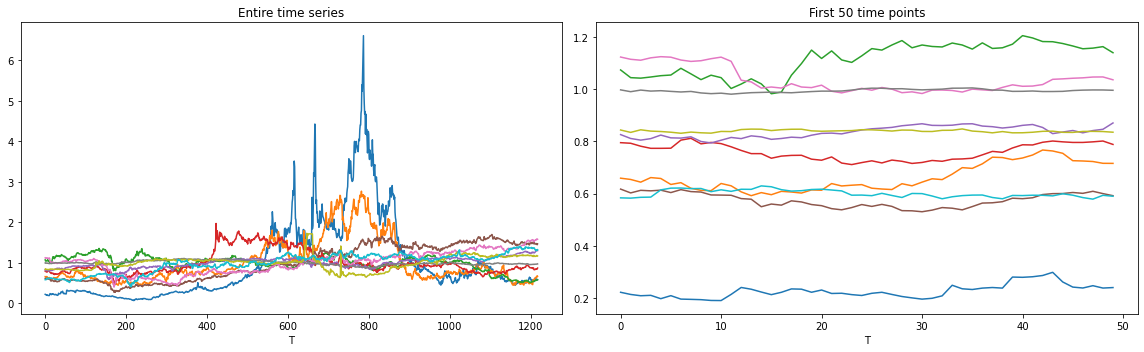

In [21]:
X = torch.tensor(time_series_data2, dtype=torch.float32, device=device)
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
for i in range(time_series_data.shape[0]):
    axarr[0].plot(time_series_data[i])
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
for i in range(time_series_data.shape[0]):
    axarr[1].plot(time_series_data[i,:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

In [22]:
cmlp = cMLP(X.shape[-1], lag=5, hidden=[100])#.cuda(device=device)
# Train with ISTA
train_loss_list = train_model_ista(
    cmlp, X, lam=0.002, lam_ridge=1e-2, lr=5e-2, penalty='H', 
    max_iter=max_iter_max,
    check_every=check_every)

----------Iter = 173----------
Loss = 0.141527
Variable usage = 100.00%
----------Iter = 346----------
Loss = 0.133034
Variable usage = 100.00%
----------Iter = 519----------
Loss = 0.125591
Variable usage = 100.00%
----------Iter = 692----------
Loss = 0.118641
Variable usage = 100.00%
----------Iter = 865----------
Loss = 0.112171
Variable usage = 100.00%
----------Iter = 1038----------
Loss = 0.105903
Variable usage = 100.00%
----------Iter = 1211----------
Loss = 0.099855
Variable usage = 100.00%
----------Iter = 1384----------
Loss = 0.093948
Variable usage = 100.00%
----------Iter = 1557----------
Loss = 0.088276
Variable usage = 100.00%
----------Iter = 1730----------
Loss = 0.082746
Variable usage = 100.00%
----------Iter = 1903----------
Loss = 0.077395
Variable usage = 100.00%
----------Iter = 2076----------
Loss = 0.072227
Variable usage = 100.00%
----------Iter = 2249----------
Loss = 0.067277
Variable usage = 100.00%
----------Iter = 2422----------
Loss = 0.062519
Variable

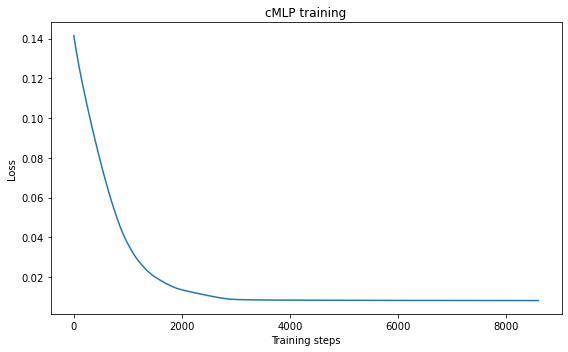

In [23]:
# Loss function plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cMLP training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

Estimated variable usage = 29.00%


[]

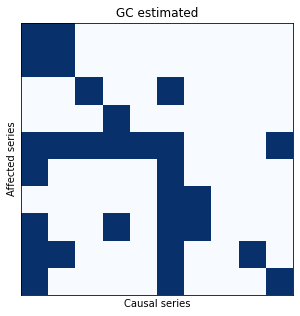

In [24]:
GC_est = cmlp.GC().cpu().data.numpy()

print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))


# Make figures
fig, axarr = plt.subplots(1, 1, figsize=(16, 5))
axarr.imshow(GC_est, cmap='Blues')
axarr.set_title('GC estimated')
axarr.set_ylabel('Affected series')
axarr.set_xlabel('Causal series')
axarr.set_xticks([])
axarr.set_yticks([])


In [25]:
GC_est

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 1]], dtype=int32)

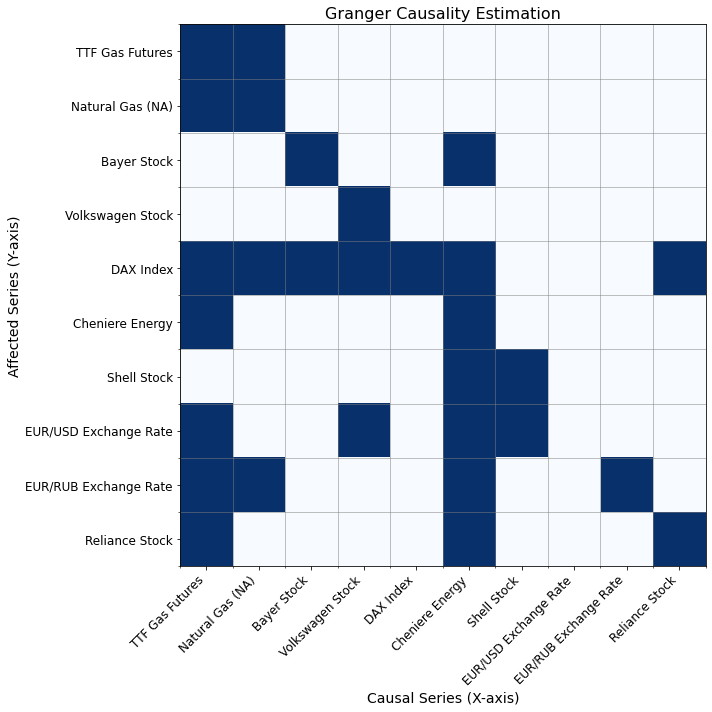

In [29]:
# Human-readable names for the series
series_names = [
    'TTF Gas Futures', 'Natural Gas (NA)', 'Bayer Stock', 'Volkswagen Stock',
    'DAX Index', 'Cheniere Energy', 'Shell Stock', 'EUR/USD Exchange Rate',
    #'Gazprom Stock', 
    'EUR/RUB Exchange Rate', 
    'Reliance Stock'
]

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the matrix
cax = ax.imshow(GC_est, cmap='Blues', aspect='auto')

# Set title and axis labels
ax.set_title('Granger Causality Estimation', fontsize=16)
ax.set_xlabel('Causal Series (X-axis)', fontsize=14)
ax.set_ylabel('Affected Series (Y-axis)', fontsize=14)

# Set ticks and labels
ax.set_xticks(np.arange(len(series_names)))
ax.set_yticks(np.arange(len(series_names)))

ax.set_xticklabels(series_names, fontsize=12, rotation=45, ha='right')
ax.set_yticklabels(series_names, fontsize=12)


# Add gridlines based on the minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-0.5, len(series_names), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(series_names), 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('granger_causality_estimation.png', dpi=300, bbox_inches='tight',  facecolor='white')
plt.show()

In [30]:
import networkx as nx

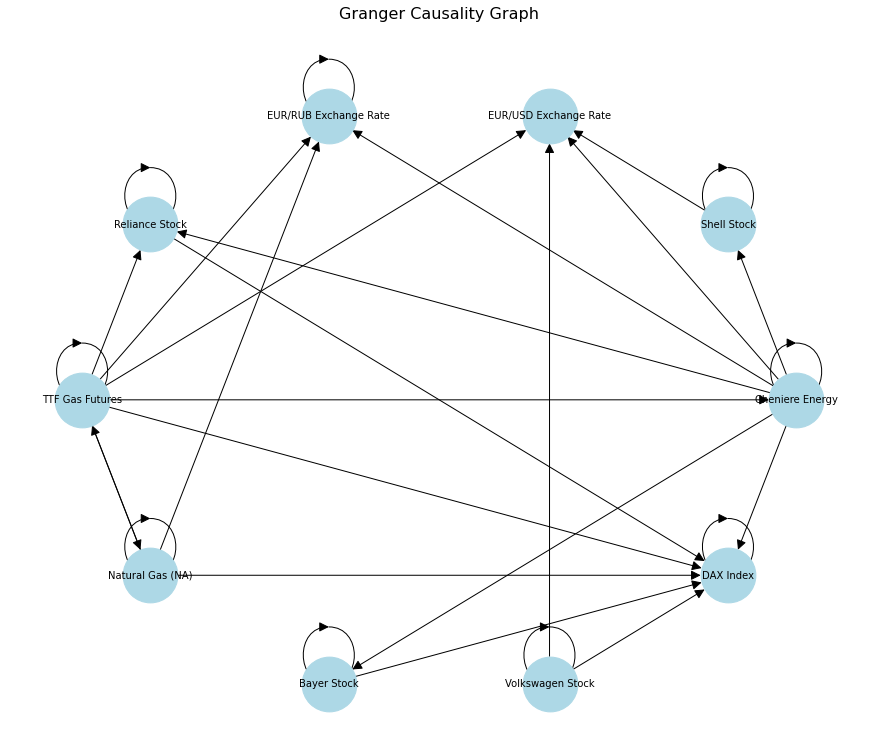

In [38]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes
for idx, name in enumerate(series_names):
    G.add_node(idx, label=name)

# Add edges based on GC_est matrix
for x in range(GC_est.shape[0]):
    for y in range(GC_est.shape[1]):
        if GC_est[x, y] == 1:
            G.add_edge(y, x)

# Define position for nodes
pos = nx.shell_layout(G)  # You can change the layout if needed

# Draw the graph
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', arrowsize=20, font_size=10,
        labels=nx.get_node_attributes(G, 'label'))

plt.title('Granger Causality Graph', fontsize=16)
plt.savefig('granger_causality_est_graph.png', dpi=300, bbox_inches='tight',  facecolor='white')
plt.show()